<a href="https://colab.research.google.com/github/fastai-energetic-engineering/ashrae/blob/master/ASHRAE_energy_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASHRAE Energy Prediction

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, kaggle]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false


In [6]:
#collapse
!pip install -Uqq fastbook dtreeviz
import fastbook
fastbook.setup_book()

In [7]:
import os
import gc
import pandas as pd
import datetime as dt
from tqdm.auto import tqdm
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
tqdm.pandas(desc="apply progress")

# Load ASHRAE energy dataset as parquet from google drive
%cd 'gdrive/MyDrive/Colab Notebooks/ashrae_parquet'
train_valid = pd.read_parquet("train_combined.parquet.snappy")

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


/content/gdrive/.shortcut-targets-by-id/1yStoxel7q5iZ4Xrus1diWNC6aTSUKqkC/ashrae


In [ ]:
train_valid.head()

,building_id,meter,timestamp,meter_reading,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
1,1,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
2,2,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
3,3,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0
4,4,0,2016-01-01,0.0,...,<NA>,1019.7,0,0.0


In [ ]:
#train.describe()
train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20125605 entries, 0 to 20125604
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         Int64         
 1   meter               Int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             Int64         
 5   primary_use         string        
 6   square_feet         Int64         
 7   year_built          Int64         
 8   floor_count         Int64         
 9   air_temperature     float64       
 10  cloud_coverage      Int64         
 11  dew_temperature     float64       
 12  precip_depth_1_hr   Int64         
 13  sea_level_pressure  float64       
 14  wind_direction      Int64         
 15  wind_speed          float64       
dtypes: Int64(9), datetime64[ns](1), float64(5), string(1)
memory usage: 2.7 GB


In [ ]:
# Engineer some features
year_fraction = train_valid["timestamp"] - train_valid["timestamp"].iloc[0]
train_valid["year_fraction"] = year_fraction / year_fraction.max()
train_valid["week_fraction"] = train_valid["timestamp"].progress_apply(lambda ts: (ts - pd.Timestamp((ts - pd.Timedelta(days=ts.dayofweek)).date())) / pd.Timedelta(days=7))
train_valid["day_fraction"] = train_valid["timestamp"].progress_apply(lambda ts: (ts - pd.Timestamp(ts.date())) / pd.Timedelta(hours=24))

# Save or load the feature engineered dataframe here
%cd '/content/gdrive/MyDrive/Colab Notebooks/ashrae'
train_valid.to_parquet("feature_enhanced_train_combined.parquet.snappy")

gc.collect()


[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/ashrae'
/content/gdrive/.shortcut-targets-by-id/1yStoxel7q5iZ4Xrus1diWNC6aTSUKqkC/ashrae


OSError: ignored

In [8]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/ashrae'
train_valid = pd.read_parquet("feature_enhanced_train_combined.parquet.snappy")

/content/gdrive/MyDrive/Colab Notebooks/ashrae


In [9]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]) or is_string_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train_valid = reduce_mem_usage(train_valid, use_float16=True)

Memory usage of dataframe is 3243.66 MB
Memory usage after optimization is: 1189.98 MB
Decreased by 63.3%


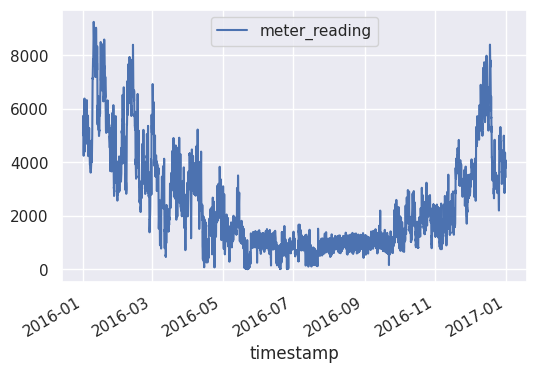

In [40]:
# Get a subset of the data, just one building and meter

train = train_valid[(train_valid['building_id']==1126) & (train_valid['meter']==2)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').plot()


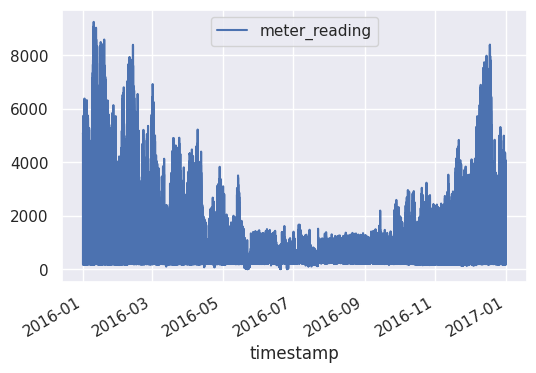

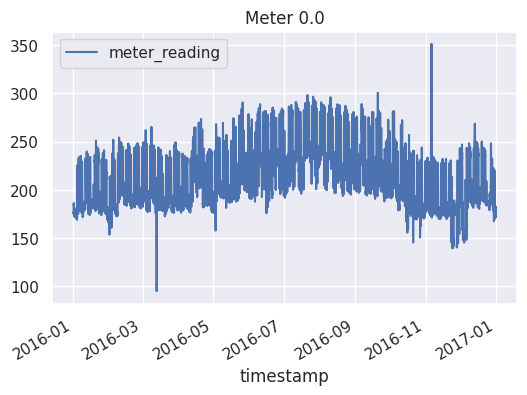

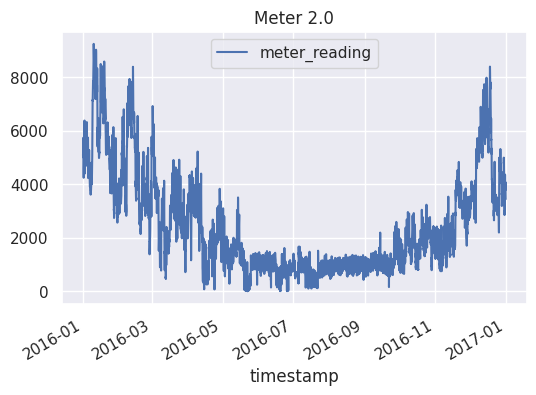

In [59]:
# Get a subset of the data, just one building (all meters)

train = train_valid[(train_valid['building_id']==1126)]
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
sns.set()
#%matplotlib inlinefig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').plot()
for i in train['meter'].unique():
    train[train['meter']==i][['timestamp', 'meter_reading']].set_index('timestamp').plot()
    plt.title('Meter ' + str(i))
    # Show/save figure as desired.
    #plt.show()

In [10]:
# Get a subset of the data, a few buildings and all meters

train = train_valid[(train_valid['building_id']>=1126)]
del train_valid
gc.collect()

188

In [15]:
# Use an splitter and load using TabularPandas then to a dataloader

# Drop rows with any column N/A, rather than FillMissing
#train = train[['timestamp', 'building_id', 'meter_reading', 'meter', 'air_temperature', 'dew_temperature']].dropna()

# 2-fold cross-validation. Build 2 models, each with half the year as training data
splits1=MaskSplitter(train['timestamp'] >= '2016-07-01')(range_of(train))
cat_names = ['building_id', 'meter', 'site_id', 'primary_use']
#cont_names = ['timestamp', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'time_diff', 'timestamp_gmt']
cont_names = ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
cont_names = ['air_temperature', 'dew_temperature', 'square_feet', 'week_fraction', 'day_fraction']
#cont,cat = cont_cat_split(train, 1, dep_var=dep_var)
procs = [Categorify, FillMissing, Normalize]
to1 = TabularPandas(train, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names, 
                   y_names='meter_reading',
                   splits=splits1)
dls1 = to1.dataloaders(bs=1024)

Notes on choice of parameters in block above:
* Using .dropna() on the input dataset before TabularPandas() is slightly better than using FillMissing.
* Normalize doesn't do much.
* The hour feature doesn't do much. Change to Owen's continuous minute feature instead.




In [49]:
dls1.show_batch()

,building_id,meter,site_id,primary_use,air_temperature_na,dew_temperature_na,air_temperature,dew_temperature,square_feet,week_fraction,day_fraction,meter_reading
0,1126,2,13,Education,False,False,-7.199218,-11.101562,72332.0,0.779785,0.458252,5619.629883
1,1126,0,13,Education,False,False,-5.601562,-14.398438,72332.0,0.416748,0.916504,198.054001
2,1126,0,13,Education,False,False,0.600097,-2.199219,72332.0,0.357178,0.500000,244.798004
3,1126,2,13,Education,False,False,20.000000,14.398438,72332.0,0.327393,0.291748,771.484009
4,1126,0,13,Education,False,False,-11.703124,-15.601563,72332.0,0.636719,0.458252,240.845993
5,1126,0,13,Education,False,False,18.906250,14.398438,72332.0,0.660645,0.625000,250.981995
6,1126,2,13,Education,False,False,1.099609,-14.398438,72332.0,0.833496,0.833496,3314.449951
7,1126,2,13,Education,False,False,8.898437,-0.600098,72332.0,0.643066,0.500000,688.476990
8,1126,0,13,Education,False,False,-0.600098,-2.199219,72332.0,0.488037,0.416748,219.115997
9,1126,2,13,Education,False,False,15.000000,1.700195,72332.0,0.708496,0.958496,1358.400024


In [ ]:
if 'train_valid' in locals():
  del train_valid
del train
gc.collect()

1044

In [20]:
# Train a tabular model

learn = tabular_learner(dls1, metrics=rmse)
learn.summary()
# Exploring the learning rates
#learn.lr_find(stop_div=False)
learn.fit_one_cycle(5, lr_max=.001)

epoch,train_loss,valid_loss,_rmse,time
0,6606906.000000,6312083.000000,2512.386719,00:53
1,2111558.000000,4070248.000000,2017.484985,00:53
2,1479085.250000,3509574.250000,1873.386719,00:52
3,1343117.000000,2945261.000000,1716.176270,00:54
4,1183140.750000,3803080.000000,1950.146973,00:52


In [21]:
building=2
meter=2
valid_xs[(valid_xs['building_id']==building) & (valid_xs['meter']==meter)]

,building_id,meter,site_id,primary_use,...,dew_temperature,square_feet,week_fraction,day_fraction
14519188,2,2,1,7,...,0.942591,-0.241339,0.260146,-1.668599
14519495,2,2,1,7,...,0.993086,-0.241339,0.280493,-1.523932
14519802,2,2,1,7,...,0.770595,-0.241339,0.302535,-1.379266
14520109,2,2,1,7,...,0.881840,-0.241339,0.322882,-1.234494
14520416,2,2,1,7,...,0.993086,-0.241339,0.343228,-1.089933
...,...,...,...,...,...,...,...,...,...
15880707,2,2,1,7,...,-1.137935,-0.241339,1.148616,1.080166
15881016,2,2,1,7,...,-1.198686,-0.241339,1.170658,1.225998
15881325,2,2,1,7,...,-1.309932,-0.241339,1.191005,1.370135
15881634,2,2,1,7,...,-1.309932,-0.241339,1.211352,1.514271


,building_id,meter,site_id,primary_use,air_temperature_na,dew_temperature_na,air_temperature,dew_temperature,square_feet,week_fraction,day_fraction,meter_reading,meter_reading_pred
0,30.0,3.0,1.0,15.0,1.0,1.0,1.414860,1.891728,-0.860350,-0.463007,0.211957,0.000000,17.956135
1,121.0,4.0,2.0,7.0,1.0,1.0,0.387676,0.993086,-0.576016,1.501291,0.067820,0.000000,42.141315
2,99.0,2.0,2.0,7.0,1.0,1.0,1.414860,2.063725,-0.820139,0.302535,-1.379266,253.020996,292.061462
3,127.0,1.0,2.0,1.0,1.0,1.0,0.647000,1.104331,0.023445,0.280493,-1.523932,474.000000,462.790527
4,178.0,3.0,2.0,4.0,1.0,1.0,0.535758,1.214788,0.785033,1.438556,-0.366284,2345.879883,471.683105
5,262.0,3.0,3.0,7.0,1.0,1.0,0.591379,1.053837,0.667190,1.004494,0.067820,583.849976,579.781677
6,199.0,4.0,2.0,2.0,1.0,1.0,1.719692,1.831766,-0.263555,0.817983,-1.234494,19.148701,-12.569182
7,84.0,1.0,1.0,4.0,1.0,1.0,-0.851021,-0.693743,0.019253,0.075331,0.501925,280.654999,266.488983
8,49.0,1.0,1.0,8.0,1.0,1.0,1.257388,1.951690,-0.782247,-0.938186,0.357789,12.385000,72.112175


Training set RMSLE: 1.7256423
Validation set RMSLE: 1.9200937


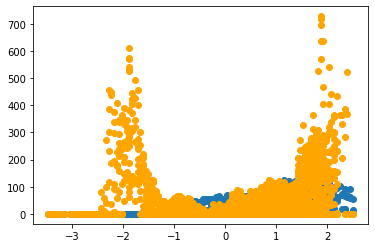

In [22]:
learn.show_results()
from sklearn.metrics import mean_squared_log_error

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y

y_pred,y_targs = learn.get_preds(ds_idx=0)
valid_y_pred,valid_y_targs = learn.get_preds()

# Set negative values to 0 because the RMSLE metric can't handle negatives
y_pred[y_pred<0]=0
valid_y_pred[valid_y_pred<0]=0
print("Training set RMSLE: " + str(np.sqrt(mean_squared_log_error(y_pred.detach().numpy(), y))))
print("Validation set RMSLE: " + str(np.sqrt(mean_squared_log_error(valid_y_pred.detach().numpy(), valid_y))))

building=2
meter=2
plt.scatter(valid_xs[(valid_xs['building_id']==building) & (valid_xs['meter']==meter)]['air_temperature'], valid_y.loc[valid_xs[(valid_xs['building_id']==building) & (valid_xs['meter']==meter)].index])
plt.scatter(valid_xs[(valid_xs['building_id']==building) & (valid_xs['meter']==meter)]['air_temperature'], pd.DataFrame(valid_y_pred, index=valid_y.index).loc[valid_xs[(valid_xs['building_id']==building) & (valid_xs['meter']==meter)].index], color='orange')

In [19]:
# Train a fast.ai decision tree
xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y
m = DecisionTreeRegressor(min_samples_leaf=10000)
m.fit(xs, y);

KeyboardInterrupt: ignored

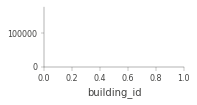

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs, y, xs.columns, 'meter_reading',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')
#dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'meter_reading',
#        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#        orientation='LR')

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
0,building_id,0.513031
1,meter,0.162360
2,site_id,0.112070
3,primary_use,0.087363
6,air_temperature,0.073426
10,day_fraction,0.020638
7,dew_temperature,0.020360
8,year_fraction,0.010549
9,week_fraction,0.000203
4,air_temperature_na,0.000000


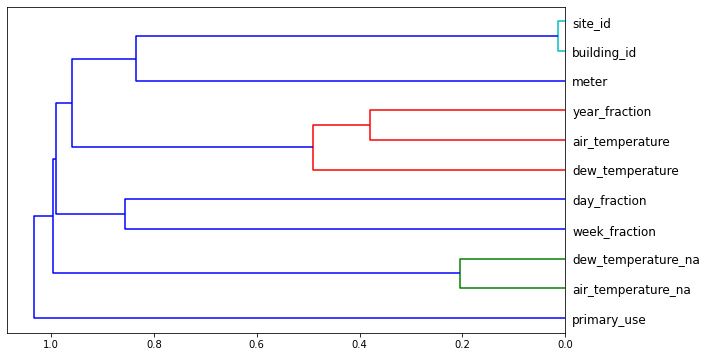

In [ ]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    
cluster_columns(xs)

Training set R2: 0.09768973662308922 RMSE: 690.1474177222669
Validation set R2: 0.10169750550873724 RMSE: 939.425644097199
Coefficients: [   0.65038416  208.0176015  -133.49886246  -39.37469677 -101.41427278
 -101.41427278   58.26409991  113.18247627]
Intercept: 458.32098517725433


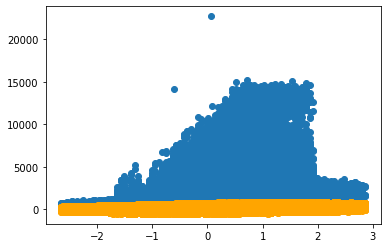

In [ ]:
# Linear regression using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

xs,y = to1.train.xs,to1.train.y
valid_xs,valid_y = to1.valid.xs,to1.valid.y
m = LinearRegression()
m.fit(xs.to_numpy(), y);
print("Training set R2: " + str(m.score(xs, y)) + " RMSE: " + str(mean_squared_error(y, m.predict(xs), squared=False)))
print("Validation set R2: " + str(m.score(valid_xs, valid_y)) + " RMSE: " + str(mean_squared_error(valid_y, m.predict(valid_xs), squared=False)))
print("Coefficients: " + str(m.coef_))
print("Intercept: " + str(m.intercept_))

#plt.scatter(xs['air_temperature'],y)
plt.scatter(valid_xs['air_temperature'], valid_y)
plt.scatter(valid_xs['air_temperature'], m.predict(valid_xs),color='orange')

Note that the scattered orange line above is due to multiple input variables yet we're just plotting against air_temperature. When just using one input variable, the line is straight.

Parameter containing:
tensor([[-0.0279, -0.2112, -0.4328]], requires_grad=True)
Parameter containing:
tensor([0.3425], requires_grad=True)
tensor(6083564.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(3157270.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3038562.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(3040172.5000, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (torch.Size([4410, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([4410])) that is different to the input size (tor

Training loss:  tensor(3001640., grad_fn=<MseLossBackward>)
Training loss:  tensor(2953377.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2978136.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2934418.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2877487.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2840216., grad_fn=<MseLossBackward>)
Training loss:  tensor(2837932.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2799506.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2836210.5000, grad_fn=<MseLossBackward>)
Training loss:  tensor(2776785.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2802382., grad_fn=<MseLossBackward>)
Training loss:  tensor(2742863., grad_fn=<MseLossBackward>)
Training loss:  tensor(2720460.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2746403.7500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2706342.2500, grad_fn=<MseLossBackward>)
Training loss:  tensor(2714497.5000, grad_fn=<MseLossBac

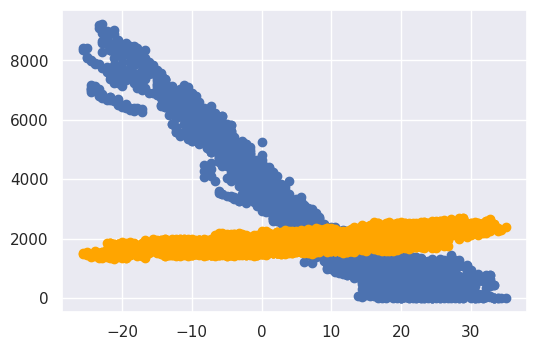

In [ ]:
# Linear regression using PyTorch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

xs,y = torch.tensor(to1.train.xs.values),torch.tensor(to1.train.y.values)
valid_xs,valid_y = torch.tensor(to1.valid.xs.values),torch.tensor(to1.valid.y.values)

# Define dataset
train_ds = TensorDataset(xs, y)
#train_ds = TensorDataset(torch.tensor(xs.values), torch.tensor(y.values))
#train_ds = Dataset.from_tensor_slices((xs, y))
print(train_ds)

# Define data loader
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

# Define model
model = nn.Linear(xs.shape[1], 1)#y.shape[1])
print(model.weight)
print(model.bias)

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=.001)

# Define loss function
import torch.nn.functional as F
loss_fn = F.mse_loss
loss = loss_fn(model(xs), y)
print(loss)

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
        print('Training loss: ', loss_fn(model(xs), y))

# Train the model for several epochs
fit(50, model, loss_fn, opt)

# Generate predictions
y_pred = model(xs)
valid_y_pred = model(valid_xs)
print("Training set R2: " + str(r2_score(y_pred.detach().numpy(), y)) + " RMSE: " + str(mean_squared_error(y_pred.detach().numpy(), y, squared=False)))
print("Validation set R2: " + str(r2_score(valid_y_pred.detach().numpy(), valid_y)) + " RMSE: " + str(mean_squared_error(valid_y_pred.detach().numpy(), valid_y, squared=False)))
print("Coefficients: " + str(model.weight))
print("Intercept" + str(model.bias))

plt.scatter(valid_xs[:,0], valid_y)
plt.scatter(valid_xs[:,0], valid_y_pred.detach().numpy(), color='orange')

To do:


1.   Figure out why continuous variables are shown as boolean
2.   Handle dates
3.   Create training and validation sets, rather than using TabularDataLoader

